# Book Rating Prediction

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from os import listdir
from os.path import isfile, join
np.random.seed(42)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Identify the bookIDs of downloaded images

In [5]:
#identify the book ids of the downloaded books
jpg_list = [f for f in listdir('./data/Grant/cover_images/') if isfile(join('./data/Grant/cover_images/', f)) and f != '4232.jpg' and 'export' not in f]

downloaded_images = pd.Series(list(map(int,[i[:-4] for i in jpg_list])))

In [6]:
#count of book cover images
len(jpg_list)

10599

### Read Goodreads dataframe and merge with jpg list

In [7]:
goodreads = pd.read_csv('./data/Grant/books.csv', error_bad_lines=False)

#merges the goodreads reviews with the pic features
cover_df = goodreads[goodreads['bookID'].isin(list(downloaded_images))]
cover_df['file_name'] = cover_df['bookID'].astype(str) + '.jpg'

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Create calculated targets

In [8]:
#rating mean norm
cover_df['average_rating_mean_norm'] = (cover_df['average_rating']-cover_df['average_rating'].mean())/cover_df['average_rating'].std()

#rating min-max norm
cover_df['average_rating_min_max'] = (cover_df['average_rating']-cover_df['average_rating'].min())/(cover_df['average_rating'].max()-cover_df['average_rating'].min())

#rating thirds
cover_df['average_rating_thirds'] = pd.qcut(cover_df['average_rating'], 3, labels=False).astype('str')

#count log
cover_df['ratings_count_log'] = (cover_df['ratings_count']+1).apply(np.log)

#count thirds
cover_df['ratings_count_thirds'] = pd.qcut(cover_df['ratings_count'], 3, labels=False).astype('str')

#summed thirds
cover_df['summed_thirds'] = (cover_df['average_rating_thirds'].astype('int') 
                                       + cover_df['ratings_count_thirds'].astype('int'))

cover_df.head()

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,file_name,average_rating_mean_norm,average_rating_min_max,average_rating_thirds,ratings_count_log,ratings_count_thirds,summed_thirds
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,1.jpg,1.831714,0.914,2,14.555394,2,4
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2.jpg,1.600537,0.898,2,14.582451,2,4
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,4.jpg,1.398257,0.884,2,8.753687,2,4
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,5.jpg,1.802817,0.912,2,14.665485,2,4
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,8.jpg,2.438554,0.956,2,10.631736,2,4


### Create image data object from cover_df and cover_images folder with a random validation set, 256 padded images, batch size of 12, and normalized pixel values

In [9]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count_thirds')
        .transform(size=(384, 256), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

### Load in model

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)
learn.load('ratings_count_segment-256-stage-1');

### Show results

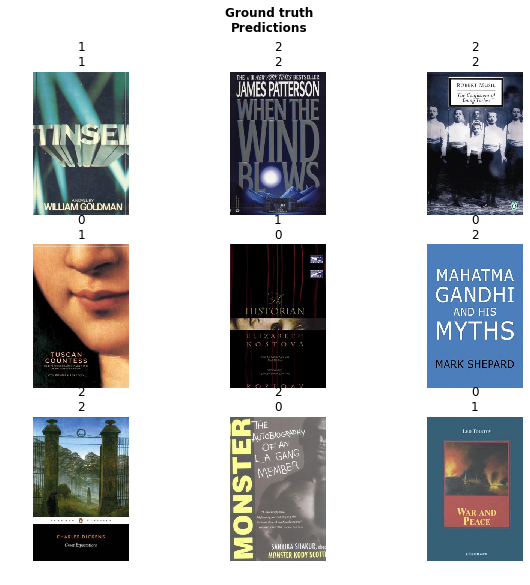

In [11]:
learn.show_results(rows=3, figsize=(10,9))

### Model architecture

In [14]:
m = learn.model.eval();
m[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=3, bias=True)
)

### Sample book cover in the top segment of ratings

Category 2

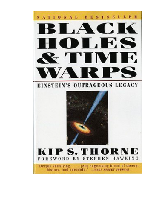

In [82]:
idx=65
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

### Creating a minibatch with this sample and putting it on the GPU

In [83]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

### Creating a function to hook into the final activations of the model

In [84]:
from fastai.callbacks.hooks import *

In [89]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [90]:
hook_a,hook_g = hooked_backward()

### Shape of final activations before and after averaging across channels 

In [91]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 12, 8])

In [92]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([12, 8])

### Displaying the regions of the book cover with the highest activation values (averaged over all channels)

In [97]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,352,0),
               interpolation='bilinear', cmap='magma');

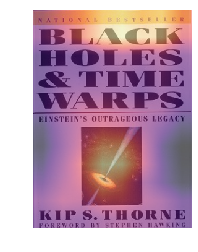

In [98]:
show_heatmap(avg_acts)